## Part 1 : Preprocessing <a class="anchor" id="chapter1"></a>

### Part 1.1 : Libraries & data loading <a class="anchor" id="section_1_1"></a>

Do this in order to install Reddit Python library:
`pip install praw`.

Library docs: https://praw.readthedocs.io/en/stable/getting_started/quick_start.html



Now we need to setup Reddit data fetching. For this we need to have a Reddit account.

We'll use posts from https://www.reddit.com/r/Paranormal/comments/gc4ive/i_made_another_big_list_of_paranormal_and_mystery/ for inspiration.

Now, create `client_id` and `client_secret`.

How?
  - Create a Reddit account if you don't have one yet
  - Go to https://www.reddit.com/prefs/apps and click `create an app`
  - Pick `script` app type. Name and description can be anything, but make sure to specify `http://localhost:8080` as `redirect uri`
  - Press `create app`. Your `client_id` is the string under **personal use script** and `client_secret` is the string next to **secret**

In [ ]:
import praw
import pandas as pd

reddit = praw.Reddit(
    client_id = '???',
    client_secret = '???',
    user_agent = 'praw'
)

# This function returns a Pandas dataframe
# containing reddit post comments, given its id
def getComments(id):
    submission = reddit.submission(id)
    pandas_list = []
    commentsList = submission.comments.list()
    for i in range(min(50, len(commentsList))):
        pandas_list.append([i, commentsList[i].body])
    df = pd.DataFrame(pandas_list)
    df.columns = ['id', 'description']
    return df

In [ ]:
# test getComments()
df = getComments('1n9pg5')

Install libraries & load data

In [ ]:
# Install spacy quietly
!pip install spacy -q

In [ ]:
# Download english language model
!python -m spacy download en_core_web_sm -q

In [ ]:
# Install wordcloud
!pip install wordcloud

1. Import pandas, numpy, spacy, sklearn (TfidfVectorizer, DBSCAN and TruncatedSVD), matplotlib and wordcloud.

   `en_core_web_sm` is a trained English pipeline.

In [1]:
import pandas as pd
import numpy as np

import spacy
import en_core_web_sm
nlp = en_core_web_sm.load()

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import DBSCAN
from sklearn.decomposition import TruncatedSVD

import matplotlib.pyplot as plt
import wordcloud

2. Read reddit comments and put it in a DataFrame named `corpus`.

In [2]:
corpus = getComments('<some reddit id>')#pd.read_csv('./sample_data.csv')

In [3]:
print(corpus.shape)
corpus.head()

(500, 2)


,id,description
0,1,Active classic boxers - There's a reason why o...
1,2,Active sport boxer briefs - Skinning up Glory ...
2,3,Active sport briefs - These superbreathable no...
3,4,"Alpine guide pants - Skin in, climb ice, switc..."
4,5,"Alpine wind jkt - On high ridges, steep ice an..."


In [4]:
print('Description of the first product : ',corpus.loc[0,'description'])

Description of the first product :  Active classic boxers - There's a reason why our boxers are a cult favorite - they keep their cool, especially in sticky situations. The quick-drying, lightweight underwear takes up minimal space in a travel pack. An exposed, brushed waistband offers next-to-skin softness, five-panel construction with a traditional boxer back for a classic fit, and a functional fly. Made of 3.7-oz 100% recycled polyester with moisture-wicking performance. Inseam (size M) is 4 1/2". Recyclable through the Common Threads Recycling Program.<br><br><b>Details:</b><ul> <li>"Silky Capilene 1 fabric is ultralight, breathable and quick-to-dry"</li> <li>"Exposed, brushed elastic waistband for comfort"</li> <li>5-panel construction with traditional boxer back</li> <li>"Inseam (size M) is 4 1/2"""</li></ul><br><br><b>Fabric: </b>3.7-oz 100% all-recycled polyester with Gladiodor natural odor control for the garment. Recyclable through the Common Threads Recycling Program<br><br>

### Part 1.2 : Text preprocessings <a class="anchor" id="section_1_2"></a>

3. Use `str` methods to clean the texts. Save cleaned-up text into a column named `clean_description`.

In [5]:
# Remove HTML elements
corpus['clean_description'] = corpus['description'].str.replace(r"<[a-z/]+>", " ") 
# Remove special characters and numbers
corpus['clean_description'] = corpus['clean_description'].str.replace(r"[^A-Za-z]+", " ") 
print('Description cleaned of the first product : ',corpus.loc[0,'clean_description'])

Description cleaned of the first product :  Active classic boxers - There's a reason why our boxers are a cult favorite - they keep their cool, especially in sticky situations. The quick-drying, lightweight underwear takes up minimal space in a travel pack. An exposed, brushed waistband offers next-to-skin softness, five-panel construction with a traditional boxer back for a classic fit, and a functional fly. Made of 3.7-oz 100% recycled polyester with moisture-wicking performance. Inseam (size M) is 4 1/2". Recyclable through the Common Threads Recycling Program.<br><br><b>Details:</b><ul> <li>"Silky Capilene 1 fabric is ultralight, breathable and quick-to-dry"</li> <li>"Exposed, brushed elastic waistband for comfort"</li> <li>5-panel construction with traditional boxer back</li> <li>"Inseam (size M) is 4 1/2"""</li></ul><br><br><b>Fabric: </b>3.7-oz 100% all-recycled polyester with Gladiodor natural odor control for the garment. Recyclable through the Common Threads Recycling Program

4. Tranform every character into lowercase.

In [6]:
# Lowercase
corpus['clean_description'] = corpus['clean_description'].str.lower()
print('Description in lower case of the first product : ',corpus.loc[0,'clean_description'])

Description in lower case of the first product :  active classic boxers - there's a reason why our boxers are a cult favorite - they keep their cool, especially in sticky situations. the quick-drying, lightweight underwear takes up minimal space in a travel pack. an exposed, brushed waistband offers next-to-skin softness, five-panel construction with a traditional boxer back for a classic fit, and a functional fly. made of 3.7-oz 100% recycled polyester with moisture-wicking performance. inseam (size m) is 4 1/2". recyclable through the common threads recycling program.<br><br><b>details:</b><ul> <li>"silky capilene 1 fabric is ultralight, breathable and quick-to-dry"</li> <li>"exposed, brushed elastic waistband for comfort"</li> <li>5-panel construction with traditional boxer back</li> <li>"inseam (size m) is 4 1/2"""</li></ul><br><br><b>fabric: </b>3.7-oz 100% all-recycled polyester with gladiodor natural odor control for the garment. recyclable through the common threads recycling p

5. Use spacy to tokenize the documents and put the result in a new column named `clean_tokens`.

In [7]:
## Tokenize the cleaned description
corpus['clean_tokens'] = corpus['clean_description'].apply(lambda x: nlp(x))
corpus.head()

,id,description,clean_description,clean_tokens
0,1,Active classic boxers - There's a reason why o...,active classic boxers - there's a reason why o...,"(active, classic, boxers, -, there, 's, a, rea..."
1,2,Active sport boxer briefs - Skinning up Glory ...,active sport boxer briefs - skinning up glory ...,"(active, sport, boxer, briefs, -, skinning, up..."
2,3,Active sport briefs - These superbreathable no...,active sport briefs - these superbreathable no...,"(active, sport, briefs, -, these, superbreatha..."
3,4,"Alpine guide pants - Skin in, climb ice, switc...","alpine guide pants - skin in, climb ice, switc...","(alpine, guide, pants, -, skin, in, ,, climb, ..."
4,5,"Alpine wind jkt - On high ridges, steep ice an...","alpine wind jkt - on high ridges, steep ice an...","(alpine, wind, jkt, -, on, high, ridges, ,, st..."


6. Remove the stop words and lemmatize `clean_tokens`

In [8]:
# Remove stop words
from spacy.lang.en.stop_words import STOP_WORDS

corpus['clean_tokens'] = corpus['clean_tokens'].apply(lambda x: [token.lemma_ for token in x if token.text not in STOP_WORDS])
corpus.head()

,id,description,clean_description,clean_tokens
0,1,Active classic boxers - There's a reason why o...,active classic boxers - there's a reason why o...,"[active, classic, boxer, -, reason, boxer, cul..."
1,2,Active sport boxer briefs - Skinning up Glory ...,active sport boxer briefs - skinning up glory ...,"[active, sport, boxer, brief, -, skin, glory, ..."
2,3,Active sport briefs - These superbreathable no...,active sport briefs - these superbreathable no...,"[active, sport, brief, -, superbreathable, -, ..."
3,4,"Alpine guide pants - Skin in, climb ice, switc...","alpine guide pants - skin in, climb ice, switc...","[alpine, guide, pant, -, skin, ,, climb, ice, ..."
4,5,"Alpine wind jkt - On high ridges, steep ice an...","alpine wind jkt - on high ridges, steep ice an...","[alpine, wind, jkt, -, high, ridge, ,, steep, ..."


7. Write all the cleaned tokens into one single string and put it in a new column named `clean_document`.

In [9]:
# Put back tokens into one single string
corpus["clean_document"] = [" ".join(x) for x in corpus['clean_tokens']]
corpus.head()

,id,description,clean_description,clean_tokens,clean_document
0,1,Active classic boxers - There's a reason why o...,active classic boxers - there's a reason why o...,"[active, classic, boxer, -, reason, boxer, cul...",active classic boxer - reason boxer cult favor...
1,2,Active sport boxer briefs - Skinning up Glory ...,active sport boxer briefs - skinning up glory ...,"[active, sport, boxer, brief, -, skin, glory, ...",active sport boxer brief - skin glory require ...
2,3,Active sport briefs - These superbreathable no...,active sport briefs - these superbreathable no...,"[active, sport, brief, -, superbreathable, -, ...",active sport brief - superbreathable - fly bri...
3,4,"Alpine guide pants - Skin in, climb ice, switc...","alpine guide pants - skin in, climb ice, switc...","[alpine, guide, pant, -, skin, ,, climb, ice, ...","alpine guide pant - skin , climb ice , switch ..."
4,5,"Alpine wind jkt - On high ridges, steep ice an...","alpine wind jkt - on high ridges, steep ice an...","[alpine, wind, jkt, -, high, ridge, ,, steep, ...","alpine wind jkt - high ridge , steep ice alpin..."


### Part 1 conclusion :
Now we have the `clean_document` feature which is cleaned. We can train some NLP model on it.

## Part 2 - Clustering model --> Identify similar products <a class="anchor" id="chapter2"></a>

1. Perform TF-IDF transformation using the data from the column `clean_document`.

In [10]:
# TF-IDF vector
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(corpus["clean_document"])

# X is a generator. We can transform that as an array
X = X.toarray()
print(X.shape)

(500, 3930)


In [11]:
# Print the 50 first words into our vocabulary
print(sorted(vectorizer.vocabulary_.items())[:50])

[('000', 0), ('03', 1), ('10', 2), ('100', 3), ('1000', 4), ('1021', 5), ('1027', 6), ('103', 7), ('1038', 8), ('1055', 9), ('106', 10), ('1070', 11), ('108', 12), ('109', 13), ('1096', 14), ('11', 15), ('110', 16), ('112', 17), ('1125', 18), ('1128', 19), ('1139', 20), ('115', 21), ('116', 22), ('1171', 23), ('118', 24), ('1188', 25), ('11c', 26), ('12', 27), ('1200', 28), ('121', 29), ('1234', 30), ('124', 31), ('125', 32), ('126', 33), ('127', 34), ('129', 35), ('1298', 36), ('12d', 37), ('13', 38), ('130', 39), ('132', 40), ('1324', 41), ('1327', 42), ('133', 43), ('1341', 44), ('135', 45), ('138', 46), ('14', 47), ('141', 48), ('144', 49)]


2. Create a DataFrame containing the result from TF-IDF

In [13]:
# Create a dataframe with tf-idf
X_df = pd.DataFrame(X, 
             columns=vectorizer.get_feature_names_out(), 
             index=["item_{}".format(x) for x in range(corpus.shape[0])] )

X_df.head()

,000,03,10,100,1000,1021,1027,103,1038,1055,...,zinger,zip,zipped,zipper,zippered,zippers,zipping,zips,zone,zones
item_0,0.0,0.0,0.000000,0.072986,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
item_1,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
item_2,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
item_3,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.049367,0.199477,0.097807,0.0,0.0,0.0,0.0
item_4,0.0,0.0,0.047788,0.047148,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.148537,0.000000,0.000000,0.0,0.0,0.0,0.0


- Each line of X correspond to a product description.
- Each column of X correspond to a word into the vocabulary.
- So each cell of X correspond to the score TF-IDF for a word in a product description.

3. Use DBSCAN to make some clustering on the TF-IDF matrix.

DBSCAN stands for Density-Based Spatial Clustering of Applications with Noise. It belongs to the unsupervised learning family of clustering algorithms.

When it comes to clustering, usually K-means or Hierarchical clustering algorithms are more popular. But they work well only when the clusters are simple to detect. They will not produce good results when the clusters have complex shapes or structures and this is where the DBSCAN algorithm gets the upper hand.

- When dealing with texts, the distance metric to be used is cosine instead of euclidean 
- eps = 0.7 and min samples = 3 enable to have almost 15 clusters without too much outliers

In [14]:
# Clustering on documents with DBSCAN
clustering = DBSCAN(eps=0.7, min_samples=3, metric="cosine", algorithm="brute")

# Fit on data 
#No need to normalize data, it already is due to TF-IDF
clustering.fit(X)

# Write cluster ids into corpus and X_df
corpus['cluster_id'] = clustering.labels_
display(corpus.head())
X_df['cluster_id'] = clustering.labels_
display(X_df.head())

,id,description,clean_description,clean_tokens,clean_document,cluster_id
0,1,Active classic boxers - There's a reason why o...,active classic boxers - there's a reason why o...,"[active, classic, boxer, -, reason, boxer, cul...",active classic boxer - reason boxer cult favor...,0
1,2,Active sport boxer briefs - Skinning up Glory ...,active sport boxer briefs - skinning up glory ...,"[active, sport, boxer, brief, -, skin, glory, ...",active sport boxer brief - skin glory require ...,0
2,3,Active sport briefs - These superbreathable no...,active sport briefs - these superbreathable no...,"[active, sport, brief, -, superbreathable, -, ...",active sport brief - superbreathable - fly bri...,0
3,4,"Alpine guide pants - Skin in, climb ice, switc...","alpine guide pants - skin in, climb ice, switc...","[alpine, guide, pant, -, skin, ,, climb, ice, ...","alpine guide pant - skin , climb ice , switch ...",0
4,5,"Alpine wind jkt - On high ridges, steep ice an...","alpine wind jkt - on high ridges, steep ice an...","[alpine, wind, jkt, -, high, ridge, ,, steep, ...","alpine wind jkt - high ridge , steep ice alpin...",0


,000,03,10,100,1000,1021,1027,103,1038,1055,...,zip,zipped,zipper,zippered,zippers,zipping,zips,zone,zones,cluster_id
item_0,0.0,0.0,0.000000,0.072986,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0
item_1,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0
item_2,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0
item_3,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.049367,0.199477,0.097807,0.0,0.0,0.0,0.0,0
item_4,0.0,0.0,0.047788,0.047148,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.148537,0.000000,0.000000,0.0,0.0,0.0,0.0,0


4. Display number of documents in each cluster

In [15]:
# Number of documents in each cluster
corpus['cluster_id'].value_counts()

cluster_id
 0    477
 1      8
-1      6
 3      5
 2      4
Name: count, dtype: int64

5. Print a sample of 3 documents that belong to 5 clusters

In [16]:
# Print sample of 3 documents for the 5 first cluster
for c in corpus['cluster_id'].value_counts().index[:5] :
    print("CLUSTER ", c , ' :')
    print('----')
    for d in corpus.loc[corpus['cluster_id']==c,:].sample(3)['clean_description']:
        print(d)
        print()
    print('-----------')

CLUSTER  0  :
----
cap 2 bottoms - simul-climbing the final pitches to beat a descending storm requires a cool head and an all-out pace. perfect for such days beneath layers, these bottoms are made from an open-knit 4-oz 100% polyester (54% recycled) that breathes, wicks perspiration, and dries in a flash. they feature a scalloped-edge elastic waistband that's brushed for softness, and side seams that are set forward to eliminate chafe. a gusseted crotch improves range of motion. with gladiodor natural odor control for the garment. recyclable through the common threads recycling program.<br><br><b>details:</b><ul> <li>fabric has an open knit that invites airflow and provides excellent wicking for endurance activities in warm to moderate temperatures</li> <li>"fastest-drying of our capilene fabrics, it insulates enough for use on chilly days and can be worn beneath other layers"</li> <li>scalloped edge elastic waistband brushed for next-to-skin softness</li> <li>side seams set forward f

6. Print the 5 most frequent words in the 5 first clusters

In [17]:
# 5 Most frequent words in each cluster
cols = [c for c in X_df.columns if c!='cluster_id']

for c in corpus['cluster_id'].value_counts().index[:5] :
    print("CLUSTER ", c)
    print(X_df.loc[X_df['cluster_id']==c,cols].mean(axis=0).sort_values(ascending=False)[0:5])
    print('-----------')

CLUSTER  0
li         0.202634
br         0.173614
oz         0.051329
pocket     0.049889
organic    0.048714
dtype: float64
-----------
CLUSTER  1
photo      0.325962
poster     0.208365
outside    0.196524
br         0.132666
print      0.120636
dtype: float64
-----------
CLUSTER  -1
li         0.207973
br         0.169180
cotton     0.092334
organic    0.092334
big        0.087633
dtype: float64
-----------
CLUSTER  3
insole        0.269740
support       0.202451
midsole       0.185557
filtration    0.174371
leather       0.169905
dtype: float64
-----------
CLUSTER  2
buckle      0.231926
aluminum    0.202539
web         0.197864
br          0.195763
belt        0.182184
dtype: float64
-----------


7. Wordcloud for the 5 first clusters

CLUSTER  0


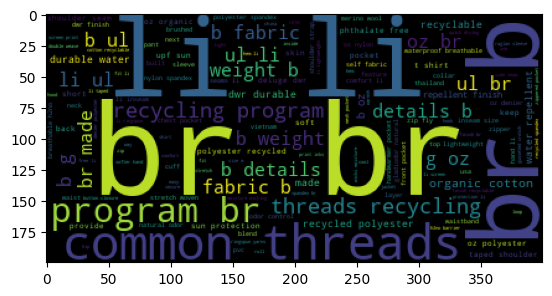

-----------
CLUSTER  1


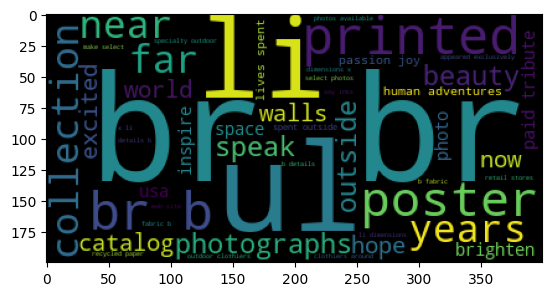

-----------
CLUSTER  -1


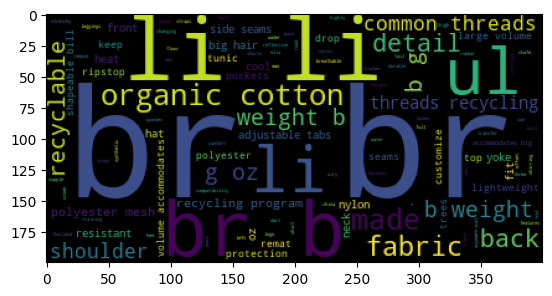

-----------
CLUSTER  3


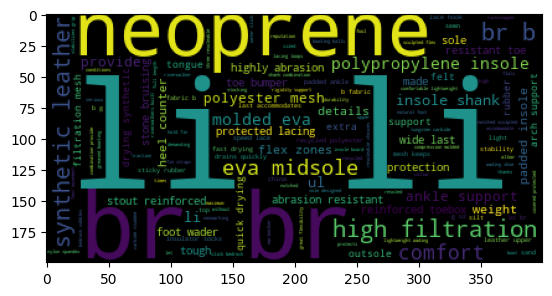

-----------
CLUSTER  2


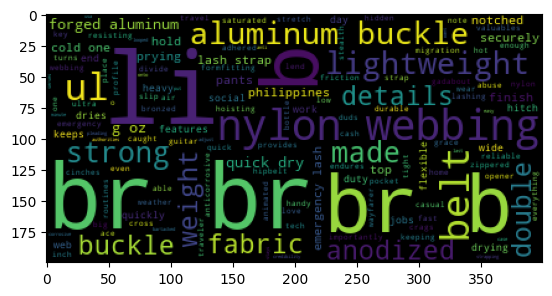

-----------


In [18]:
# Word cloud for the 5 first clusters
wd = wordcloud.WordCloud()
for c in corpus['cluster_id'].value_counts().index[:5] :
    print("CLUSTER ", c)
    texts = " ".join(corpus.loc[corpus['cluster_id']==c,'clean_description'])
    cloud = wd.generate(texts)
    plt.imshow(cloud)
    plt.show()
    print('-----------')

## Part 3 - Recommender system <a class="anchor" id="chapter3"></a>

Now, we use the clusters created from part 1 to build a recommender system. 
The aim is to be able to suggest to a user some products that are similar to the ones he is interested in. To do this, we consider that products belonging to the same cluster are similar.

In [19]:
corpus.head()

,id,description,clean_description,clean_tokens,clean_document,cluster_id
0,1,Active classic boxers - There's a reason why o...,active classic boxers - there's a reason why o...,"[active, classic, boxer, -, reason, boxer, cul...",active classic boxer - reason boxer cult favor...,0
1,2,Active sport boxer briefs - Skinning up Glory ...,active sport boxer briefs - skinning up glory ...,"[active, sport, boxer, brief, -, skin, glory, ...",active sport boxer brief - skin glory require ...,0
2,3,Active sport briefs - These superbreathable no...,active sport briefs - these superbreathable no...,"[active, sport, brief, -, superbreathable, -, ...",active sport brief - superbreathable - fly bri...,0
3,4,"Alpine guide pants - Skin in, climb ice, switc...","alpine guide pants - skin in, climb ice, switc...","[alpine, guide, pant, -, skin, ,, climb, ice, ...","alpine guide pant - skin , climb ice , switch ...",0
4,5,"Alpine wind jkt - On high ridges, steep ice an...","alpine wind jkt - on high ridges, steep ice an...","[alpine, wind, jkt, -, high, ridge, ,, steep, ...","alpine wind jkt - high ridge , steep ice alpin...",0


1. Create a function named `find_similar_items` that will return the 5 item ids belonging to the same cluster as the product `item_id`.

In [20]:
def find_similar_items(item_id):
    """
    Return 5 product ids belonging to the same cluster as item_id
    """
    cluster_id = corpus.loc[corpus['id']==item_id, 'cluster_id'].values[0]
    similar_items = corpus.loc[corpus['cluster_id']==cluster_id,:].sample(5)
    similar_item_ids = similar_items['id'].unique()
    return similar_item_ids

2. Use `input()` function to allow the user to choose a product and submit some suggestions of similar items.

In [21]:
# For printing in colors
class bcolors:
    OKBLUE = '\033[94m'
    OKGREEN = '\033[92m'

In [ ]:
product_id = int(input("What product would you like to buy ? "))
print()
try:
    item_desc = corpus.loc[corpus['id']==product_id, 'clean_description'].values[0]
except:
    print('Product not found in database. Please enter a valid product id.')
else:
    print(f"{bcolors.OKBLUE}Product found in database, description below :")
    print(item_desc)
    print()
    
    print("Based on the analysis of the products' descriptions, you might also be interested by the following products : ")
    print()

    for i in find_similar_items(product_id):
        print(f"{bcolors.OKGREEN}Item #", i)
        print(corpus.loc[corpus['id']==i, 'clean_description'].values[0])
        print('--------------------')

## Part 4 - LSA for topic extraction <a class="anchor" id="chapter4"></a>

- Latent Semantic Analysis, or LSA, is one of the foundational techniques in topic modeling. The core idea is to take a matrix of what we have — documents and terms — and decompose it into a separate document-topic matrix and a topic-term matrix.

- The main goal of this part is to find relevant topics for each documents. Contrary to clustering, a unique documents can have multiple topics. For example Sport and Politics.

1. Use TruncatedSVD to make some topic extraction from the TF-IDF matrix.

In [27]:
# Train SVD model
svd_model = TruncatedSVD(n_components=12) # We test on 12 topics
lsa = svd_model.fit_transform(X)
topic_encoded_df = pd.DataFrame(lsa, columns = ["topic_" + str(i) for i in range(lsa.shape[1])])
topic_encoded_df["documents"] = corpus['clean_description']
topic_encoded_df.head()

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,documents
0,0.380079,-0.040823,0.177250,0.055728,-0.120012,-0.033834,-0.048715,-0.002708,-0.135915,0.036568,-0.041461,0.028167,active classic boxers - there's a reason why o...
1,0.379993,-0.064544,0.103426,0.077871,-0.027845,0.071073,-0.087911,-0.026023,-0.137328,-0.042997,0.011589,0.155620,active sport boxer briefs - skinning up glory ...
2,0.370185,-0.081343,0.099787,0.017680,-0.027094,0.118873,-0.017449,0.045475,-0.074563,-0.024469,-0.013761,0.208260,active sport briefs - these superbreathable no...
3,0.463639,-0.247918,-0.122712,-0.128130,0.035976,-0.047298,-0.032420,-0.054333,-0.098322,-0.096527,0.106466,0.020294,"alpine guide pants - skin in, climb ice, switc..."
4,0.440263,-0.263901,-0.053578,-0.232029,-0.045133,-0.051252,0.015853,0.055013,-0.010531,-0.122104,0.168272,-0.017004,"alpine wind jkt - on high ridges, steep ice an..."


Contrary to clustering, LSA allows to map each document to a mix of several topics. For this reason, it's a bit more difficult to interpret the topics as categories : one document can actually be related to several topics at a time. To make things easier, we can extract the main topic of each document.

2. Create a new column named `main_topic` in `topic_encoded_df` where we store the main topics related to each document.

In [28]:
def extract_main_topics(x):
    """
    Return the main topic for each document. The main topic is that have the maximum value for each line
    """
    topics = np.abs(x)
    main_topic = topics.sort_values(ascending=False).index[0]
    return main_topic

# Initialize column main_topics with 0
topic_encoded_df.loc[:, 'main_topic'] = 0

for i, row in topic_encoded_df.iloc[:,:-2].iterrows():
    topic_encoded_df.loc[i, 'main_topic'] = extract_main_topics(row)

topic_encoded_df.head()

/var/folders/jr/7vzj1lzn0rx65bxcqn8nrwqw0000gn/T/ipykernel_24632/3040406549.py:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'topic_0' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  topic_encoded_df.loc[i, 'main_topic'] = extract_main_topics(row)


,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,documents,main_topic
0,0.380079,-0.040823,0.177250,0.055728,-0.120012,-0.033834,-0.048715,-0.002708,-0.135915,0.036568,-0.041461,0.028167,active classic boxers - there's a reason why o...,topic_0
1,0.379993,-0.064544,0.103426,0.077871,-0.027845,0.071073,-0.087911,-0.026023,-0.137328,-0.042997,0.011589,0.155620,active sport boxer briefs - skinning up glory ...,topic_0
2,0.370185,-0.081343,0.099787,0.017680,-0.027094,0.118873,-0.017449,0.045475,-0.074563,-0.024469,-0.013761,0.208260,active sport briefs - these superbreathable no...,topic_0
3,0.463639,-0.247918,-0.122712,-0.128130,0.035976,-0.047298,-0.032420,-0.054333,-0.098322,-0.096527,0.106466,0.020294,"alpine guide pants - skin in, climb ice, switc...",topic_0
4,0.440263,-0.263901,-0.053578,-0.232029,-0.045133,-0.051252,0.015853,0.055013,-0.010531,-0.122104,0.168272,-0.017004,"alpine wind jkt - on high ridges, steep ice an...",topic_0


3. Count each main topic in the corpus 

In [30]:
topic_encoded_df['main_topic'].value_counts()

main_topic
topic_0     376
topic_1      40
topic_2      19
topic_5      18
topic_7      17
topic_11     11
topic_9       8
topic_4       8
topic_8       3
Name: count, dtype: int64

- topic_0 is the most represented topic, as it's the main topic for more than `50%` of the documents of the corpus.

4. Use the attribute `components_` of the SVD model to print the 5 most important words in each topic.

In [32]:
# Create DataFrame containing the description of each topic in terms of the words in the vocabulary
topics_description = pd.DataFrame(svd_model.components_, columns = vectorizer.get_feature_names_out(), 
                                  index = ['topic_' + str(i) for i in range(svd_model.components_.shape[0])])

# Compute absolute values of coefficients
topics_description = topics_description.apply(np.abs, axis = 1)

# Each word is map with a score of relevance for each topic
topics_description.head()

,000,03,10,100,1000,1021,1027,103,1038,1055,...,zinger,zip,zipped,zipper,zippered,zippers,zipping,zips,zone,zones
topic_0,0.001985,0.000374,0.035283,0.094318,0.000350,0.000197,0.000267,0.008630,0.000309,0.000191,...,0.000434,0.058804,0.000575,0.056878,0.049328,0.005117,0.001141,0.005155,0.002809,0.002931
topic_1,0.000341,0.000777,0.007100,0.052640,0.000536,0.000486,0.000311,0.021174,0.000626,0.000303,...,0.000800,0.052285,0.001106,0.096729,0.078979,0.010357,0.002656,0.010967,0.004543,0.008142
topic_2,0.001548,0.000854,0.036688,0.021352,0.000600,0.000433,0.000094,0.000861,0.000720,0.000125,...,0.000810,0.055324,0.000480,0.053849,0.067102,0.008974,0.002302,0.009216,0.003974,0.007363
topic_3,0.003829,0.001401,0.081411,0.071436,0.001091,0.000750,0.000011,0.005897,0.001264,0.000134,...,0.000692,0.078634,0.001072,0.116829,0.060055,0.013371,0.005007,0.017839,0.004603,0.014820
topic_4,0.002036,0.000443,0.011749,0.064069,0.000517,0.000073,0.000045,0.002354,0.000288,0.000308,...,0.000322,0.024564,0.000083,0.014935,0.006989,0.003768,0.000680,0.002502,0.012588,0.009417


In [33]:
# Loop over each topic and print the 5 most important words
for i,row in topics_description.iterrows():
    print('TOPIC :', i)
    print(row.sort_values(ascending=False)[0:5].index.tolist())
    print()
    print('-------------------------')
    print()

TOPIC : topic_0
['li', 'br', 'oz', 'organic', 'pocket']

-------------------------

TOPIC : topic_1
['organic', 'shirt', 'cotton', 'print', 'ringspun']

-------------------------

TOPIC : topic_2
['merino', 'odor', 'wool', 'pocket', 'control']

-------------------------

TOPIC : topic_3
['inseam', 'organic', 'cotton', 'button', 'waterproof']

-------------------------

TOPIC : topic_4
['merino', 'wool', 'wash', 'sun', 'capilene']

-------------------------

TOPIC : topic_5
['82', 'spandex', 'nylon', 'coverage', '18']

-------------------------

TOPIC : topic_6
['sun', 'upf', 'cotton', 'organic', 'inseam']

-------------------------

TOPIC : topic_7
['strap', 'waterproof', 'barrier', 'deni', 'mesh']

-------------------------

TOPIC : topic_8
['sun', 'protection', 'upf', '30', 'collar']

-------------------------

TOPIC : topic_9
['photo', 'poster', 'outside', 'waterproof', 'spandex']

-------------------------

TOPIC : topic_10
['fleece', 'photo', 'waterproof', 'poster', 'wind']

-----

5. Make a wordcloud describing each topic and compare to the ones we obtain with clustering

In [34]:
topic_encoded_df.head()

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,documents,main_topic
0,0.380079,-0.040823,0.177250,0.055728,-0.120012,-0.033834,-0.048715,-0.002708,-0.135915,0.036568,-0.041461,0.028167,active classic boxers - there's a reason why o...,topic_0
1,0.379993,-0.064544,0.103426,0.077871,-0.027845,0.071073,-0.087911,-0.026023,-0.137328,-0.042997,0.011589,0.155620,active sport boxer briefs - skinning up glory ...,topic_0
2,0.370185,-0.081343,0.099787,0.017680,-0.027094,0.118873,-0.017449,0.045475,-0.074563,-0.024469,-0.013761,0.208260,active sport briefs - these superbreathable no...,topic_0
3,0.463639,-0.247918,-0.122712,-0.128130,0.035976,-0.047298,-0.032420,-0.054333,-0.098322,-0.096527,0.106466,0.020294,"alpine guide pants - skin in, climb ice, switc...",topic_0
4,0.440263,-0.263901,-0.053578,-0.232029,-0.045133,-0.051252,0.015853,0.055013,-0.010531,-0.122104,0.168272,-0.017004,"alpine wind jkt - on high ridges, steep ice an...",topic_0


-------------------------

TOPIC  topic_0


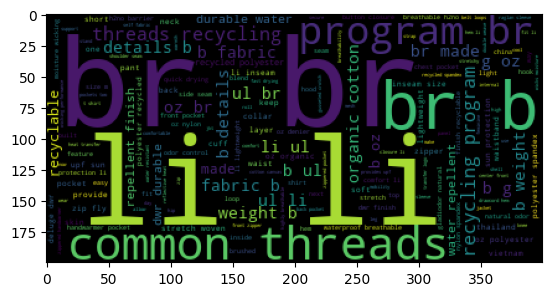


-------------------------

TOPIC  topic_1


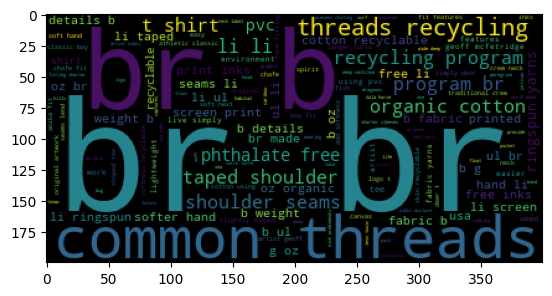


-------------------------

TOPIC  topic_2


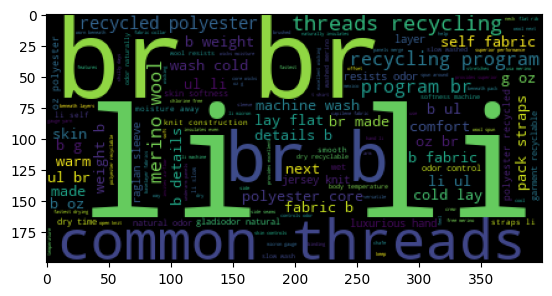


-------------------------

TOPIC  topic_3
cannot create wordcloud for this topic
-------------------------

TOPIC  topic_4


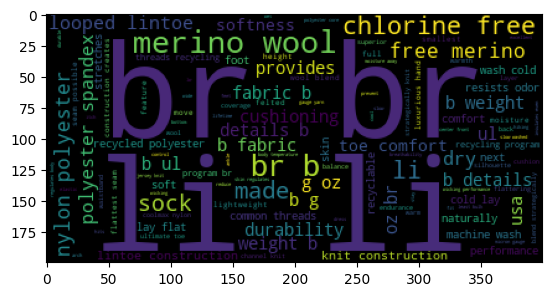


-------------------------

TOPIC  topic_5


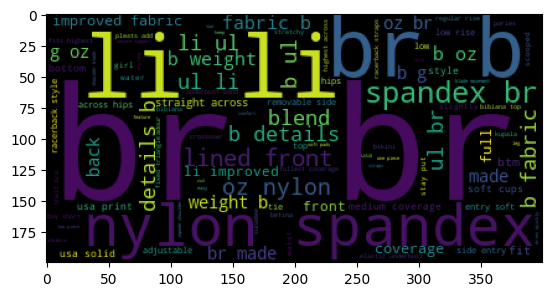


-------------------------

TOPIC  topic_6
cannot create wordcloud for this topic
-------------------------

TOPIC  topic_7


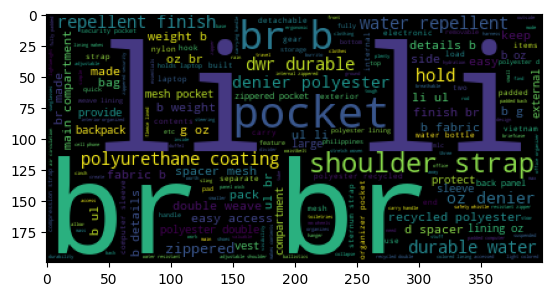


-------------------------

TOPIC  topic_8


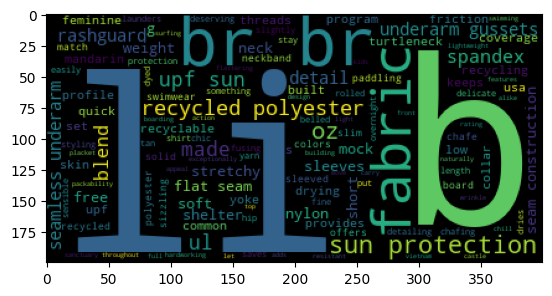


-------------------------

TOPIC  topic_9


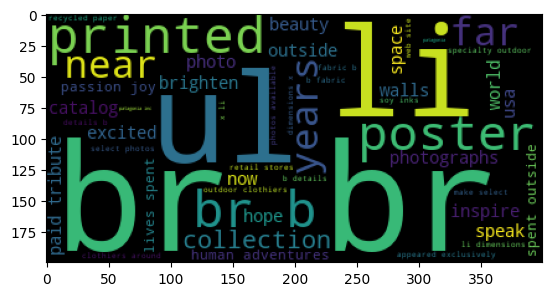


-------------------------

TOPIC  topic_10
cannot create wordcloud for this topic
-------------------------

TOPIC  topic_11


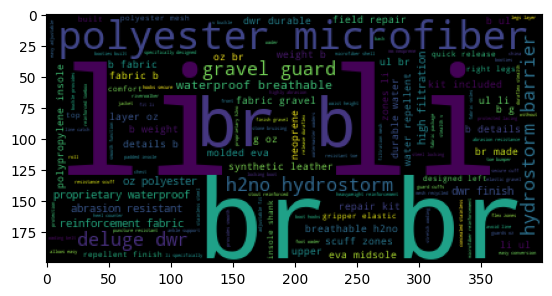

In [36]:
# Loop over each topic and create wordcloud from documents that are related to this main topic
wd = wordcloud.WordCloud()

cols = [c for c in topic_encoded_df.columns if 'topic_' in c]

for t in cols:
    print('-------------------------')
    print()
    print('TOPIC ', t)
    
    # Handle topics that are not main topics for any document in the corpus
    if (topic_encoded_df['main_topic']==t).any() == False :
        print('cannot create wordcloud for this topic')
        continue
    
    texts = " ".join(topic_encoded_df.loc[topic_encoded_df['main_topic']==t,'documents'])
    cloud = wd.generate(texts)
    plt.imshow(cloud)
    plt.show()
    
    print()

## Conclusion

- It's difficult to compare the results from the clustering and LSA, in particular because we didn't get exactly the same number of "topics" for both algorithms. However, the wordclouds are not fundamentally different (for example, both algorithms identify a group of documents or topic related to sun protection, organic cotton or merino wood).

- The major difference between these two approaches is that clustering maps a given document to a single group, whereas LSA links a document to several topics. For this reason, text clustering is usually more suitable for applications related to similarity measurements (for example, building a recommender system),  whereas LSA is widely used for topic modelling.